In [1]:
!pip install ipywidgets
!pip install seaborn
!pip install fastprogress

In [2]:
import torch.nn as nn
import torch.utils.model_zoo as model_zoo
from IPython import embed
from collections import OrderedDict, defaultdict
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from fastprogress.fastprogress import master_bar, progress_bar

In [3]:
model_urls = {
    'cifar10': 'http://ml.cs.tsinghua.edu.cn/~chenxi/pytorch-models/cifar10-d875770b.pth',
    'cifar100': 'http://ml.cs.tsinghua.edu.cn/~chenxi/pytorch-models/cifar100-3a55a987.pth',
}

class CIFAR(nn.Module):
    def __init__(self, features, n_channel, num_classes):
        super(CIFAR, self).__init__()
        assert isinstance(features, nn.Sequential), type(features)
        self.features = features
        self.classifier = nn.Sequential(
            nn.Linear(n_channel, num_classes)
        )
        # print(self.features)
        # print(self.classifier)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for i, v in enumerate(cfg):
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            padding = v[1] if isinstance(v, tuple) else 1
            out_channels = v[0] if isinstance(v, tuple) else v
            conv2d = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=padding)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(out_channels, affine=False), nn.ReLU()]
            else:
                layers += [conv2d, nn.ReLU()]
            in_channels = out_channels
    return nn.Sequential(*layers)

def cifar10(n_channel, pretrained=None):
    cfg = [n_channel, n_channel, 'M', 2*n_channel, 2*n_channel, 'M', 4*n_channel, 4*n_channel, 'M', (8*n_channel, 0), 'M']
    layers = make_layers(cfg, batch_norm=True)
    model = CIFAR(layers, n_channel=8*n_channel, num_classes=10)
    if pretrained:
        m = model_zoo.load_url(model_urls['cifar10'], progress=False)
        state_dict = m.state_dict() if isinstance(m, nn.Module) else m
        assert isinstance(state_dict, (dict, OrderedDict)), type(state_dict)
        model.load_state_dict(state_dict)
    return model

def cifar100(n_channel, pretrained=None):
    cfg = [n_channel, n_channel, 'M', 2*n_channel, 2*n_channel, 'M', 4*n_channel, 4*n_channel, 'M', (8*n_channel, 0), 'M']
    layers = make_layers(cfg, batch_norm=True)
    model = CIFAR(layers, n_channel=8*n_channel, num_classes=100)
    if pretrained:
        m = model_zoo.load_url(model_urls['cifar100'], progress=False)
        state_dict = m.state_dict() if isinstance(m, nn.Module) else m
        assert isinstance(state_dict, (dict, OrderedDict)), type(state_dict)
        model.load_state_dict(state_dict)
    return model, state_dict

In [4]:
model, original_state_dict = cifar100(128,True)
model = model.cuda()

In [5]:
test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR100(
        root='/raid/cifar', train=False, download=True,
        transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ])),
    batch_size=1000, shuffle=False)

Files already downloaded and verified


In [6]:
def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.cuda(), target.cuda()
            output = model(data)
            test_loss += F.cross_entropy(output, target).item()
            pred = output.data.max(1)[1]  # get the index of the max log-probability
            correct += pred.eq(target).sum().item()

    test_loss = test_loss / len(test_loader) # average over number of mini-batch
    acc = 100. * correct / len(test_loader.dataset)
    # print('\tTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)'.format(
    #     test_loss, correct, len(test_loader.dataset), acc))
    return test_loss, acc
    
test(model, test_loader)


(1.6086876749992371, 74.27)

In [7]:
def concat_tensor_to_numpy(tensor_list):
    l = [i.detach().cpu().flatten().numpy() for i in tensor_list]
    return np.concatenate(l)

Layer 2: Mean: 0.140791
Layer 5: Mean: 0.099818
Layer 9: Mean: 0.101263
Layer 12: Mean: 0.102282
Layer 16: Mean: 0.104511
Layer 19: Mean: 0.105760
Layer 23: Mean: 0.104919
Layer 28: Mean: 0.121009


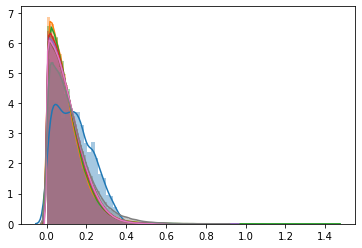

In [8]:
## get statistic of model's weights

for m_idx, m in enumerate(model.modules()):
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        all_weights = concat_tensor_to_numpy(m.parameters())
        sns.distplot(np.abs(all_weights))
        print('Layer %d: Mean: %f'%(m_idx, np.mean(np.abs(all_weights))))

In [16]:
a = torch.tensor([0.5,0.5])
b = torch.tensor([0.2,0.8])
print(torch.norm(a),torch.norm(b))

tensor(0.7071) tensor(0.8246)


In [9]:
def relative_randsign(tensor, scale):
    noise = torch.empty_like(tensor).uniform_(-1,1).sign_().add_(0.1).sign_() * scale * tensor.abs()
    tensor.data.add_(noise)
    
def relative_max(tensor, scale):
    noise = torch.empty_like(tensor).uniform_(-1,1) * scale * tensor.abs()
    tensor.data.add_(noise)   
    
def abs_randsign(tensor, scale):
    noise = torch.empty_like(tensor).uniform_(-1,1).sign_().add_(0.1).sign_() * scale * tensor.abs().mean()
    tensor.data.add_(noise)    
    
def abs_max(tensor, scale):
    noise = torch.empty_like(tensor).uniform_(-1,1) * scale * tensor.abs().mean()
    tensor.data.add_(noise)

def one_exp_paramlayer(model, original_state_dict, pert_func, scale):
    model.load_state_dict(original_state_dict)
    for m_idx, m in enumerate(model.modules()):
        if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
            for t in m.parameters():
                pert_func(t, scale)
    test_loss, acc = test(model, test_loader)
    return test_loss, acc
    
    
def repeat_exp(num_times, model, original_state_dict, pert_func, scale):
    test_loss_l = []
    test_acc_l  = []
    for exp_idx in range(num_times):
        test_loss, acc = one_exp_paramlayer(model, original_state_dict, pert_func, scale)
        test_loss_l.append(test_loss)
        test_acc_l.append(acc)
    return np.mean(test_loss_l), np.mean(test_acc_l)

In [10]:
res_list = {}

### Relative RandSign

In [11]:
res_list['relative_randsign'] = defaultdict(list)
for i in progress_bar(np.linspace(0.01, 0.5, num=60)):
    loss, acc = repeat_exp(5, model, original_state_dict, pert_func=relative_randsign, scale=i)
    res_list['relative_randsign']['loss'].append(loss)
    res_list['relative_randsign']['acc'].append(acc)
    res_list['relative_randsign']['scale'].append(i)

### Relative Max

In [12]:
res_list['relative_max'] = defaultdict(list)
for i in progress_bar(np.linspace(0.01, 0.5, num=60)):
    loss, acc = repeat_exp(5, model, original_state_dict, pert_func=relative_max, scale=i)
    res_list['relative_max']['loss'].append(loss)
    res_list['relative_max']['acc'].append(acc)
    res_list['relative_max']['scale'].append(i)

### Abs RandSign

In [13]:
res_list['abs_randsign'] = defaultdict(list)
for i in progress_bar(np.linspace(0.01, 0.5, num=60)):
    loss, acc = repeat_exp(5, model, original_state_dict, pert_func=abs_randsign, scale=i)
    res_list['abs_randsign']['loss'].append(loss)
    res_list['abs_randsign']['acc'].append(acc)
    res_list['abs_randsign']['scale'].append(i)

### Abs Max

In [14]:
res_list['abs_max'] = defaultdict(list)
for i in progress_bar(np.linspace(0.01, 0.5, num=60)):
    loss, acc = repeat_exp(5, model, original_state_dict, pert_func=abs_max, scale=i)
    res_list['abs_max']['loss'].append(loss)
    res_list['abs_max']['acc'].append(acc)
    res_list['abs_max']['scale'].append(i)

### Plot

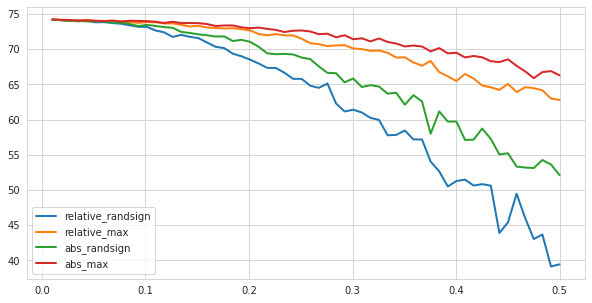

In [15]:
sns.set_style('whitegrid')
plt.figure(figsize=[10,5])
plt.plot(res_list['relative_randsign']['scale'], res_list['relative_randsign']['acc'], 
         linewidth=2, label='relative_randsign')
plt.plot(res_list['relative_max']['scale'], res_list['relative_max']['acc'], 
         linewidth=2, label='relative_max')
plt.plot(res_list['abs_randsign']['scale'], res_list['abs_randsign']['acc'], 
         linewidth=2, label='abs_randsign')
plt.plot(res_list['abs_max']['scale'], res_list['abs_max']['acc'], 
         linewidth=2, label='abs_max')
plt.legend()